In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from datetime import datetime
import tensorflow
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot
from pmdarima import auto_arima
from tqdm import tqdm

In [2]:
!pip install xlrd

### Introduction

As stock market prices exhibit random walk (Fama, 1995), it is considered the most
challenging task to predict the magnitude and directional changes of stock prices as it has always
been a knotty problem (Meher et al., 2021). Therefore, investors always demand accurate stock
market forecasting as correct prediction about share prices ultimately facilitates them to make an
informed decision in their future investment plans.

ARIMA is currently wildely used to predict these trends. Mid to long term horizons could be predicted from past historical data. With the arrival of machne learning, even short term horizons could be predicted by adding a neural network to the ARIMA method. Among RF, SVM and ANN, ANN seemed to have delivered the best results which is why we will choose it for this study. 

This study aims to forecast Nestlé's stock price by using its daily closing price serie. To begin, we will assess weither or not the stock price can be predicted from conventional time serie models. Then, we will build our hybrid machine learning model and find the best model (with the lowest error rate and highest accuracy). Linear and non linear models will be considered. Our hope is to reach enough predictive confidence for investors to rely on our model to make successfull investments.

### Preparing the dataset for the time serie analysis

In [47]:
data= pd.read_csv('AAPL.csv')
df = pd.DataFrame(data)
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [48]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [49]:
df = df.rename(columns={"Date": "date", "Close": "close", 'Open':'open', 'High':'highest', 'Low':'lowest','Volume':'volume'})
df['returns'] = ((df['close'] - df['open']) / df['open']) * 100

In [50]:
df.describe()

,open,highest,lowest,close,Adj Close,volume,returns
count,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03,1237.000000
mean,97.302373,98.482615,96.177393,97.377136,96.077147,1.175146e+08,0.096422
std,46.379108,46.972240,45.775240,46.395806,46.747085,5.525444e+07,1.567675
min,35.994999,36.430000,35.500000,35.547501,34.309586,3.519590e+07,-7.257864
25%,50.792500,51.250000,50.422501,50.825001,49.438148,8.079120e+07,-0.722194
50%,87.852501,88.692497,86.522499,87.932503,86.583694,1.031623e+08,0.102243
75%,142.750000,144.300003,140.669998,142.649994,141.868362,1.374632e+08,1.018239
max,182.630005,182.940002,179.119995,182.009995,180.959732,4.265100e+08,6.658804


### Checking the stationary of the data: stock value

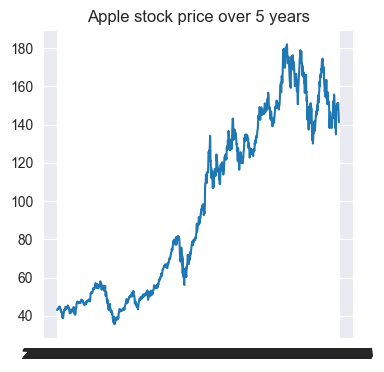

In [51]:
x = df['date']
y = df['close']
plt.figure(figsize=(4, 4))
plt.title('Apple stock price over 5 years')
plt.grid(True)
plt.plot(x,y)

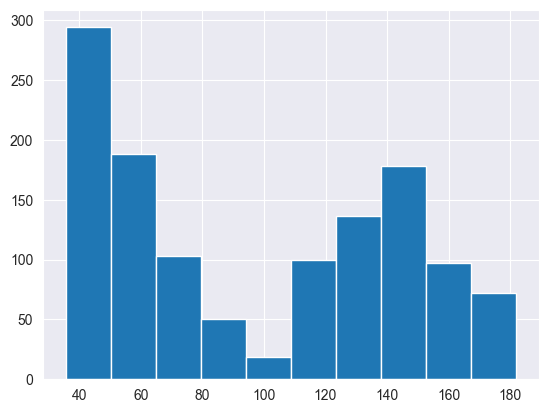

In [52]:
y.hist()
plt.show()

In [53]:
#spliting the data into 5 chunks
chunks = np.split(y[:1200], indices_or_sections=10)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 44.14933343  51.08889601  44.61929163  55.12327097  72.06943723
 105.09416633 127.5584166  140.53591635 166.19850065 152.5289167 ]
[  5.37395618  19.81082694  19.68275311  30.41370273  39.47645561
 207.45205677  44.09524944  87.78586446  86.38886059 115.53333911]


#### Observation:

there appears to be a trend in the data. The p-value will confirm if weather or not the data is stationary.

In [54]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [55]:
print(pvalue)

0.7534412094971532


#### Conclusion:

We fail to reject the null hypothesis, meaning the dataset is non-stationary if we work with closing prices. However, there is another approach which consists in computing the returns which are supposed to be normally distributed around 0.

#### Analyzing the correlogram

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


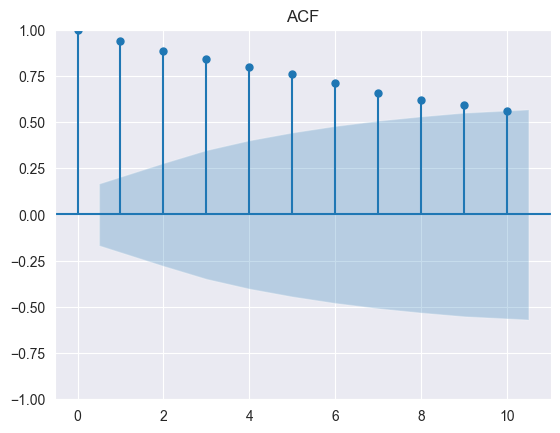

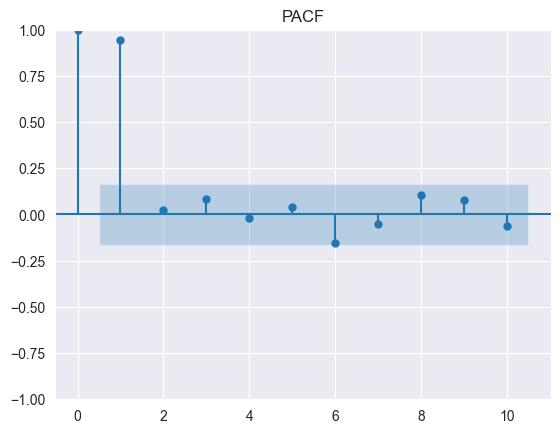

In [56]:
#Autocorrelation
acf_plot = plot_acf(y[1100:], lags=10, title='ACF')
#Partial Auto-correlation
pacf_plot = plot_pacf(y[1100:], lags=10, title='PACF')

#### Observation:

The autocorrelations are positive for many number of lags (10), so the series needs further differencing. The stock return (difference between opening and closing stock price) might provide the mean to reach stationarity.

### Building a forecasting ARIMA model

The ARMA models combines the AR models and the MA models. The ARMA(p,q) contains the AR(p) and the MA(q) and can be used for univariate time series.

The main assumption in time series analysis is that the time series is stationary and this is not the case for many pratical situations. The solution to this can be found in the Autoregressive Integrated Moving Average(ARIMA) model. The ARIMA (p,d,q) introduces the possibility to apply differencing to the data d times in order to make it stationary. After the differenciation, the model becomes ARMA(p,q).

ARIMA is a natural extension to the class of ARMA models — they can reduce a non-stationary series to a stationary series using a sequence of differences.

ARIMA model has 3 parameters:

P — Auto regressive feature of the model (number of lags of Y to be used as predictors)

D — Differencing order (minimum number of differencing needed to make the series stationary)

Q — Moving average feature of the model (number of lagged forecast errors that should go into the ARIMA Model)


#### Finding the order of differencing (d)

The purpose of differencing it to make the time series stationary. Let's start with a first order of differencing.

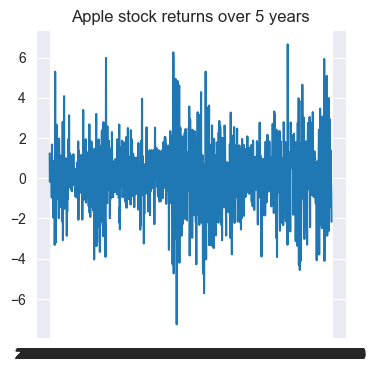

In [59]:
x = df['date']
y = df['returns']
plt.figure(figsize=(4, 4))
plt.title('Apple stock returns over 5 years')
plt.grid(True)
plt.plot(x,y)

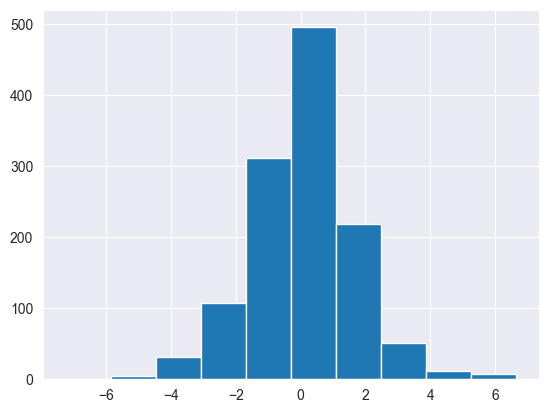

In [60]:
y.hist()
plt.show()

#### Observation:

the data seems to be distributed around a mean of 0 which could mean it is stationary. The p-value will confirm it:

In [61]:
#spliting the data into 5 chunks
chunks = np.split(y[:1200], indices_or_sections=10)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 0.04415071 -0.0339437   0.15740627  0.08921747  0.38838927 -0.0295903
 -0.04535559  0.13008424  0.17281505  0.1119135 ]
[1.69599928 1.88588302 1.64479105 1.07451231 3.91911846 4.05731023
 2.06716572 1.17694205 2.66310502 3.41736651]


In [62]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [63]:
print(pvalue)

9.903814179882287e-11


#### Conclusion:

P_value < 0.05, so we reject the null hypothesis, meaning the dataset is stationary if we work with stock returns.

### Analyzing the correlogram

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


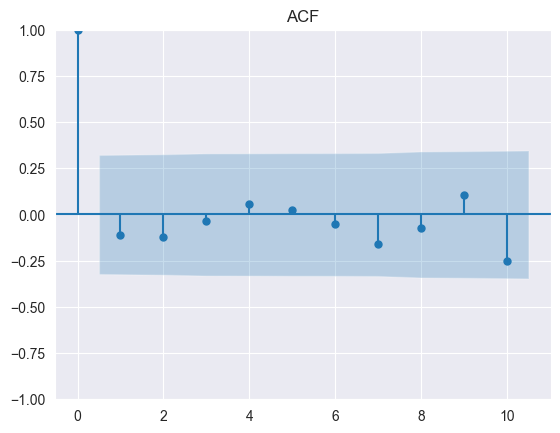

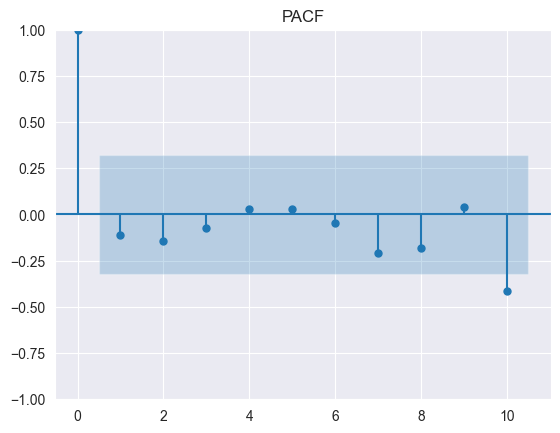

In [64]:
#Autocorrelation
acf_plot = plot_acf(y[1200:], lags=10, title='ACF')
#Partial Auto-correlation
pacf_plot = plot_pacf(y[1200:], lags=10, title='PACF')

#### Observation:

we notice that the ACF and the PACF cut off at lag 1. We also notice that on lag 10, we have a strong signal on the PACF (representing the AR part of an ARMA model) which could be due to the fact that the stock market is open 5 days a week. The first order differencing seems to have made the data stationary.

#### Finding the AR term (p)

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. The PACF plot has a significant spike only at lag 10, meaning that all the higher-order autocorrelations are effectively explained by the lag-10 autocorrelation. We will be conservative and take a p = 0 to start with and then compute again with a p = 10.

#### Finding the MA term (q)

To find this parameter, we can simply take a look at the ACF for the number of MA terms. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series. The ACF cuts off at lag 1, so we will take q = 0.

#### Building the ARIMA models

In [65]:
# Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit()
    prediction = model_fit.forecast()
    print('Model parameters = %s' % (list(model_fit.params)))
    print(model_fit.summary())
    return prediction

#### ARIMA (1,0,0)

In [66]:
nb_elements = len(y[1000:])
#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(nb_elements * 0.7)
TrainingData = y[0:TrainingSize]
TestData = y[TrainingSize:nb_elements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Test = [x for x in TestData]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(Test)):
    ActualValue =  Test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 0,1,0)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    print('')
    #add it in the list
    Predictions.append(Prediction)
    print(Prediction)
    Actual.append(ActualValue)

Model parameters = [2.907038753108732]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  165
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -320.210
Date:                Sat, 10 Dec 2022   AIC                            642.420
Time:                        22:00:22   BIC                            645.520
Sample:                             0   HQIC                           643.679
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.9070      0.189     15.343      0.000       2.536       3.278
Ljung-Box (L1) (Q):                  30.97   Jarque-Bera (JB):                96.85
Prob(Q):

Test Mean Absolute percentage error: 3.931


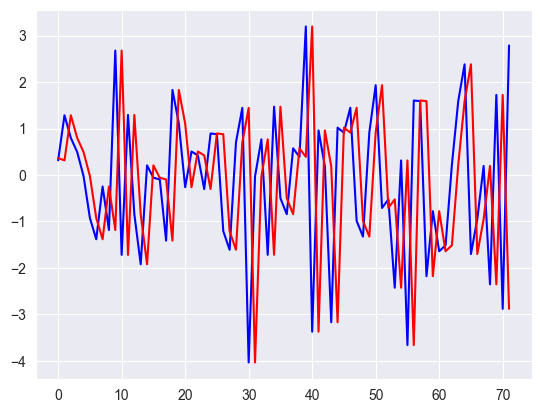

In [67]:
#Print MSE to see how good the model is
Error = mean_absolute_percentage_error(Test, Predictions)
print('Test Mean Absolute percentage error: %.3f' % Error)
# plot
#pyplot.plot(y)
pyplot.plot(Test, color='blue')
pyplot.plot(Predictions, color='red')
pyplot.show()

#### RIMA (1,1,0)

In [156]:
nb_elements = len(y[1000:])
#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(nb_elements * 0.7)
TrainingData = y[0:TrainingSize]
TestData = y[TrainingSize:nb_elements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Test = [x for x in TestData]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(Test)):
    ActualValue =  Test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 1,1,0)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    print('')
    #add it in the list
    Predictions.append(Prediction)
    print(Prediction)
    Actual.append(ActualValue)

Model parameters = [-0.43007177189306217, 2.3653541709083177]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  165
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -303.405
Date:                Sat, 10 Dec 2022   AIC                            610.810
Time:                        18:34:40   BIC                            617.009
Sample:                             0   HQIC                           613.326
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4301      0.042    -10.276      0.000      -0.512      -0.348
sigma2         2.3654      0.153     15.487      0.000       2.066   

Test Mean Absolute percentage error : 2.985


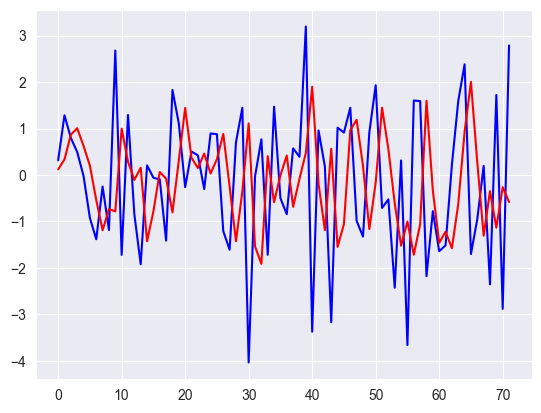

In [158]:
#Print MSE to see how good the model is
Error = mean_absolute_percentage_error(Test, Predictions)
print('Test Mean Absolute percentage error : %.3f' % Error)
# plot
#pyplot.plot(y)
pyplot.plot(Test, color='blue')
pyplot.plot(Predictions, color='red')
pyplot.show()

#### Observation:

There appears to be quite a lot of variability in our model's prediction signal which translates into a relatively high MSE (in regard to the series mean of 0.08) and a poor predictive performance.

For the ARIMA (1,0,0), the constant coefficient is significant (p>z). For the ARIMA (1,1,0), both the L1 and the constant coefficients are significant.

#### Conclusion:

So, we seem to have a decent ARIMA model. But is that the best? We need to dig further to draw relevant conclusions that is to predict the future. In the next section, a bot will be trained to take decisions based on the ARIMA's (1,0,0) predicted return values, to buy or sell stock shares with hope to make a profit !

#### Auto ARIMA forecast Python function

In [37]:
model = auto_arima(y[1000:], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1254.261, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1256.149, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1256.127, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1252.628, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.132 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  237
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -625.314
Date:                Sat, 10 Dec 2022   AIC                           1252.628
Time:                        21:44:19   BIC                           1256.092
Sample:                             0   HQIC                          1254.024
                                - 237                                         
Co

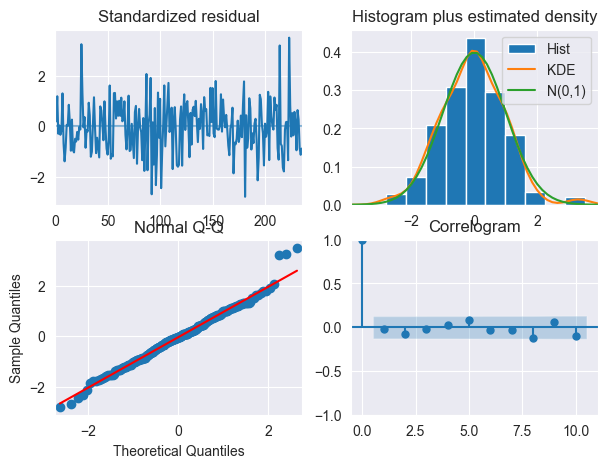

In [38]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

#### Observation:

The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. The density plot suggest normal distribution with mean zero. Overall, this model seems like a better fit. Let's move on to the next step, setting up the stock bot and comparing its financial performance based on different ARIMA / AR models.



#### Setting up the bot

In [86]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None

    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[1100:].items(), total=len(returns.iloc[1100:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            curr_holding=False
            amt *= (1+r)
            events_list.append(('s', date, r))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = y[:date]

        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit()

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1

        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
                ((type(order) == float and np.random.random() < order)
                 or (type(order) == tuple and pred > thresh)
                 or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:

        plt.figure(figsize=(10,4))
        plt.plot(prices)

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt


In [87]:
tickerSymbol = 'AAPL'
prices = df.open[1000:]
returns = df.returns[1000:]

0it [00:00, ?it/s]


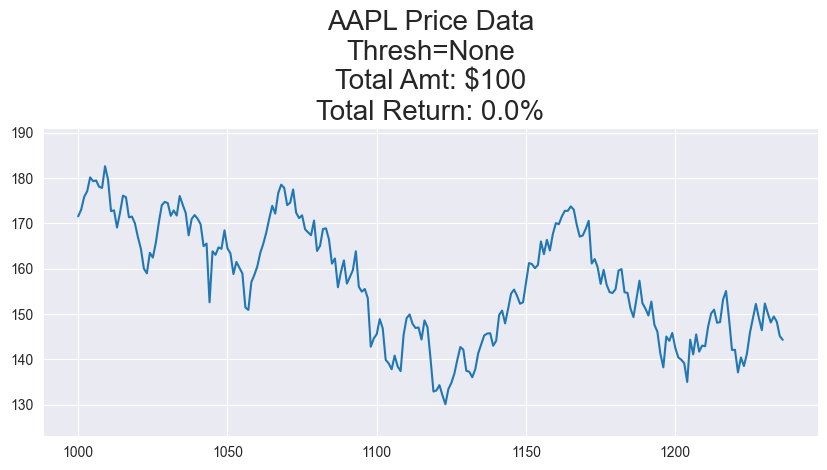

100

In [88]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

#### Further Improvements

Forecasting Apple's stock value can be improved by:

- Constantly updating model parameters (costly to compute)
- Inputting additional economical factors that impact stock values and their correlations into account (harder to compute)
- Model parameters can also be updated via machine learning and optimisation techniques (next step of this study)

Financial markets can move in any direction and this makes it very hard, if not impossible, to accurately predict exchange rates. Having said that, the sole purpose of forecasting exchange rates via ARIMA is to help us in taking calculated decisions that maximise returns and minimise risks. Forecasted exchange rates are dependent on the assumptions imposed by ARIMA model which are based on auto regression, integrated and moving average concepts.

ARIMA is a simple yet powerful model. It assumes that the historic values dictate behaviour of present. It also assumes that the data does not contain anomalies, is stationary and model parameters along with error term is constant.

Although ARIMA does not take stresses in market data as input (which are complexe and difficult to conceptualize) such as economical downturns and disruptives political changes, or correlations of all risk factors to forecast stock markets but the simple example demonstrated above can be useful for forecasting stable stocks in normal conditions in which past behaviour dictates present and future values.

### LSTM model